# Analysis of the Bosch data set

This notebook analyzes the Bosch data set and extracts meta-data for further processing from it.


The initial labelling file `signs004_ground_truth.csv` contains 16.133 instances with the following data (per row):
* Filename
* Width
* Height
* Roi.X1
* Roi.Y1
* Roi.X2
* Roi.Y2
* ClassId    

The additional labeling files added in April (`signs001_ground_truth.csv`, `signs003_ground_truth.csv`, `signs006_ground_truth.csv`) contain an additional 2.695, 6.421 and 12.870 instances each, respectively. Data ordering remains the same

---
### 1) Import and Preview

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import pickle
import seaborn as sns
path="csv_files/"
from matplotlib import pyplot as plt

load sign name dict

### If you using Windows
write down with different new line character 

In [6]:
original = "../sign_recognition/dict/sign_names_dict.pkl"
destination = "../sign_recognition/dict/sign_names_dict_win.pkl"

content=''
outsize = 0
with open(original, 'rb') as infile:
    content = infile.read()
with open(destination, 'wb') as output:
    for line in content.splitlines():
        outsize += len(line) + 1
        output.write(line + str.encode('\n'))

print("Done. Saved %s bytes." % (len(content)-outsize))

Done. Saved -1 bytes.


### EndIf

In [7]:
with open("../sign_recognition/dict/sign_names_dict_win.pkl", "rb") as f:
    sign_names = pickle.load(f)

In [8]:
import sys
print(sys.version_info)
df = pd.read_csv(path+'signs004_ground_truth.csv')
df['ClassId'].replace(sign_names, inplace=True)
df.head()  # prints top 5 rows

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00001.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%)
1,00001.png,640,480,364,167,412,212,Parken Bereich (parking zone)
2,00002.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%)
3,00002.png,640,480,364,167,412,212,Parken Bereich (parking zone)
4,00003.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%)


Evaluate additionally labeled videos

In [17]:
import os

previously_labeled = path+'signs004_ground_truth.csv'

frames_added_april = []
for filename in os.listdir(path):
    if filename.endswith('.csv') and filename != previously_labeled:
        frames_added_april.append(pd.read_csv(path+filename))

df_added_april = pd.concat(frames_added_april)
df_added_april['ClassId'].replace(sign_names, inplace=True)
df_added_april.head()

2019-01-09-13-00-05.csv
bosch_2018_16_36.csv
signs001_ground_truth.csv
2019-01-09-13-05-43.csv
2019-01-09-13-01-41.csv
signs004_ground_truth.csv
signs003_ground_truth.csv
bosch_2018_17_24.csv
2019-01-09-13-55-01.csv
signs006_ground_truth.csv
bosch_2018_17_08.csv
2019-01-20-15-59-41.csv
2019-01-09-13-24-37.csv
bosch_2018_17_54.csv
2019_05_19-17-44-13_Labels.csv


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,frame0000.jpg,640,480,475,151,554,228,60 Zone Anfang (speed limit 60 start)
1,frame0000.jpg,640,480,481,227,507,267,Pedestrian
2,frame0000.jpg,640,480,234,242,280,282,Vorgeschriebene Vorbeifahrt rechts (pass by on...
3,frame0001.jpg,640,480,475,151,554,228,60 Zone Anfang (speed limit 60 start)
4,frame0001.jpg,640,480,481,227,507,267,Pedestrian


In [18]:
grouped_classes = df.groupby('ClassId').count()['Width']
grouped_classes = grouped_classes.reset_index()  # Makes the index go from 0-17.
grouped_classes.columns = ['ClassId', 'Amount'] 

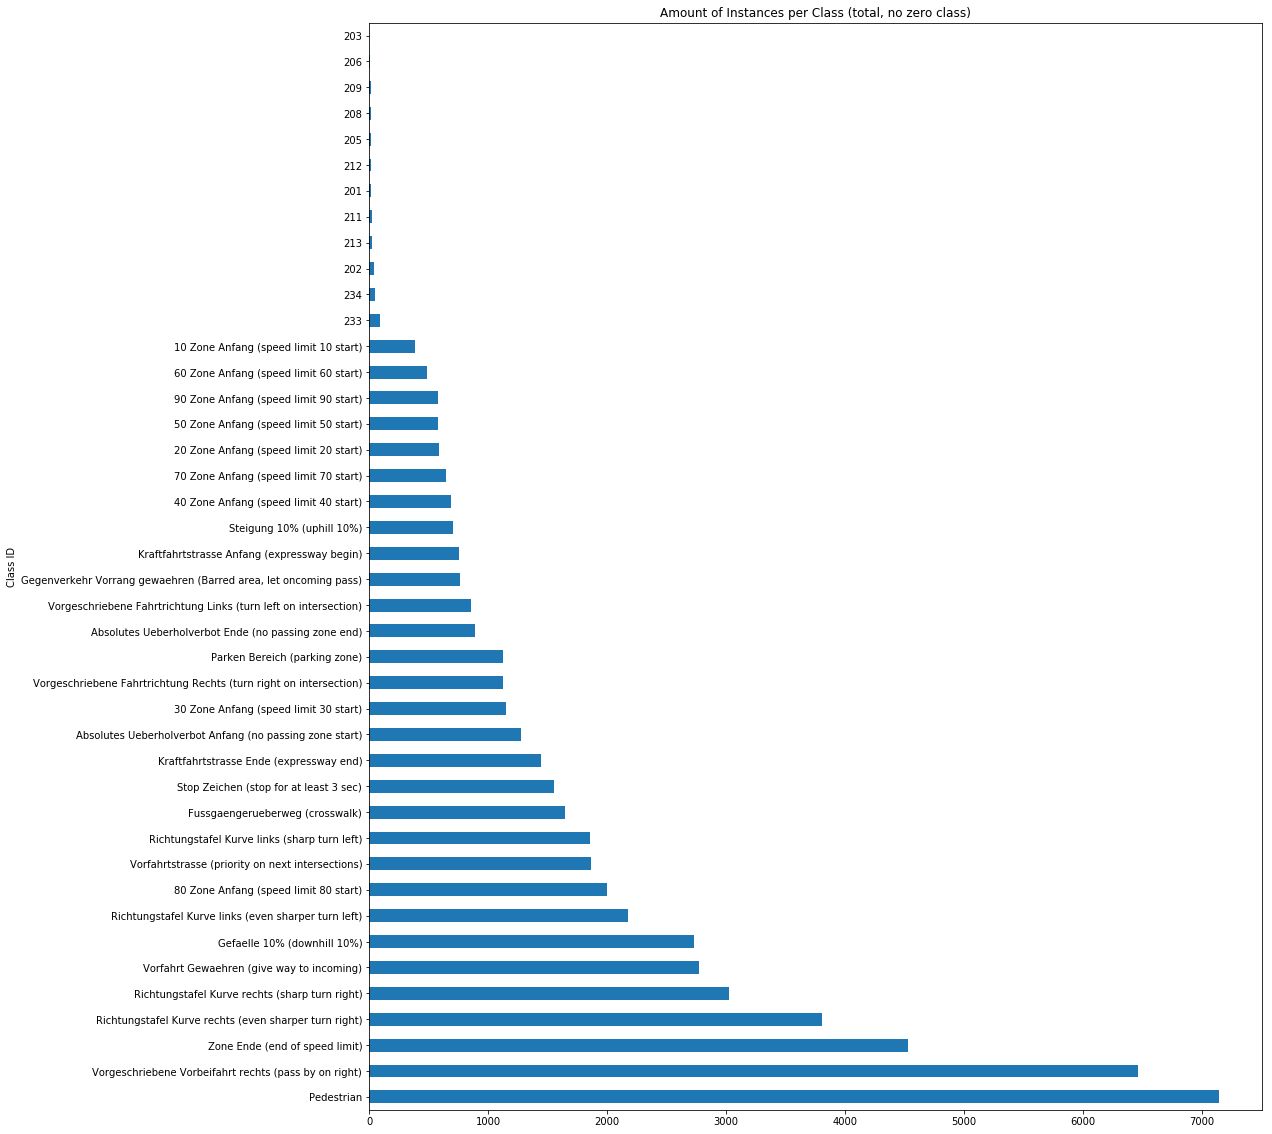

  Total Amount: 55896
Minimum Amount: 1
Maximum Amount: 7145
 Without empty: 47227

                                              ClassId  Amount
41                                                203       1
40                                                206       9
38                                                208      14
39                                                209      14
37                                                205      15
36                                                212      17
35                                                201      18
34                                                211      24
33                                                213      26
32                                                202      38
31                                                234      47
30                                                233      93
29              10 Zone Anfang (speed limit 10 start)     388
28              60 Zone Anfang (speed limit 60 s

In [19]:
# 6) display total statistics
df_all = pd.concat([df, df_added_april])
df_all = df_all.groupby('ClassId').count()
df_all_with = df_all.groupby('ClassId').count()
df_all.drop(sign_names[43], inplace=True)
df_all = df_all[['Filename']]
df_all.reset_index(inplace=True)
df_all.columns = ['Class ID', 'Amount']
#df_all['Class ID'].replace(sign_names, inplace=True)
df_all=df_all.sort_values(['Amount'],ascending=False)
df_all.set_index('Class ID', inplace=True)

#all_grouped_classes = df_all.groupby('ClassId').count()['Width']  # Group the dataframe by classes.
df_all.plot(kind='barh', figsize=(16,20),  title='Amount of Instances per Class (total, no zero class)',
            legend=False)
plt.show()
df_all2 = df_all.reset_index()  
df_all2.columns = ['ClassId', 'Amount']  
print("  Total Amount: {}".format(df_all2['Amount'].sum()))
print("Minimum Amount: {}".format(df_all2['Amount'].min()))
print("Maximum Amount: {}".format(df_all2['Amount'].max()))
print(" Without empty: {}\n".format(df_all2['Amount'].sum() - grouped_classes['Amount'].max()))
print(df_all2.sort_values(['Amount']))

---
### 4) Clean for "Time-Axis"

Since all images are taken from a video with 30 fps, most of them show the same scene (even the same pixels with little to no difference to the previous images). This is especially obvious if you inspect a series of images belonging to the same street sign. As a consequence those images yield no variety during training (no generalization) and only amplify overfitting.

Therefore, we want to get as much **distinct** images as possible. A trivial approach to achieve this, is to drop all images that are too *close in time* to a *base image*. E.g. a 2 second scene showing a *give way* sign, which corresponds to ~60 images. Given the heuristic, we drop x images that are too close to *image y*. x being 15 and y being the first image in this series, we would only keep the images [1, 16, 31, 46].

In [26]:
df_clean

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,TrackFrame
0,00001.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%),00001.png
1,00001.png,640,480,364,167,412,212,Parken Bereich (parking zone),00001.png
2,00002.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%),00002.png
3,00002.png,640,480,364,167,412,212,Parken Bereich (parking zone),00002.png
4,00003.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%),00003.png
5,00003.png,640,480,364,167,412,212,Parken Bereich (parking zone),00003.png
6,00004.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%),00004.png
7,00004.png,640,480,364,167,412,212,Parken Bereich (parking zone),00004.png
8,00005.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%),00005.png
9,00005.png,640,480,364,167,412,212,Parken Bereich (parking zone),00005.png


In [24]:
# We want to distinguish between images that are to close to one another in time .
# e.g. mulitple images from the same 1 second long video snippet.


# We want to get the frame time.
df_clean = pd.concat([df, df_added_april])
df_clean['TrackFrame'] = df_clean['Filename']  # Copy the Filename column.
df_clean['TrackFrame'] = df_clean['TrackFrame'].str.extract('(\d{5})', expand=True).astype(int)  # Extract the frame sequence number.

classes = df_without_background_grouped['ClassId'].values  # Get all ClassIds (without background)

amount_keep = dict((cl, 0) for cl in classes)
amount_drop = dict((cl, 0) for cl in classes)

index_to_drop = []

for cl in classes:
    track_frames = df_clean[df_clean['ClassId'] == cl]['TrackFrame'].values  # Get all FrameIDs.
    
    running_track_frame = 0
    keep_amount, drop_amount = 0, 0
    
    for track_frame in track_frames:
        if (track_frame - running_track_frame) > 15:  # entries to keep
            running_track_frame = track_frame
            keep_amount += 1
        else:  # entries to drop
            to_drop = df_clean[(df_clean['ClassId'] == cl) & (df_clean['TrackFrame'] == track_frame)]
            drop_amount += 1
            index_to_drop.append(to_drop.index.values[0])
    
    amount_keep[cl] = keep_amount
    amount_drop[cl] = drop_amount

#print(index_to_drop)
df_clean = df_clean.drop(df_clean.index[sorted(index_to_drop)])
df_clean = df_clean.drop(df_clean[df_clean['ClassId'] == sign_names[43]].index)
        
print("Images per class that are being kept: ", amount_keep)
print("\nImages per class that are being droped: ", amount_drop)

print("\nImage-Count before: {}".format(df_all['Amount'].sum()-grouped_classes['Amount'].max()))
print("Image-Count after:  {}".format(len(df_clean)))

ValueError: cannot convert float NaN to integer

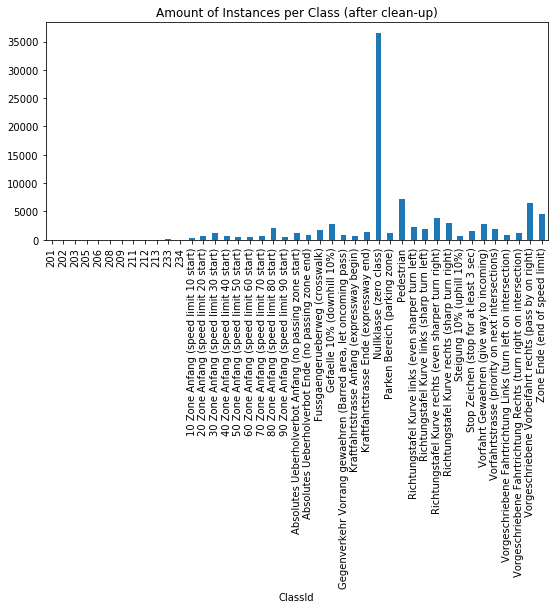

ClassId
201                                                                     18
202                                                                     38
203                                                                      1
205                                                                     15
206                                                                      9
208                                                                     14
209                                                                     14
211                                                                     24
212                                                                     17
213                                                                     26
233                                                                     93
234                                                                     47
10 Zone Anfang (speed limit 10 start)                                  388
20 Zone Anfang (s

In [27]:
df_clean_plot = df_clean.groupby('ClassId').count()['Width']  # Group the dataframe by classes.
df_clean_plot.plot(kind='bar', figsize=(9,4),  title='Amount of Instances per Class (after clean-up)', legend=False)
plt.show()

print(df_clean_plot)

### 5) Compare with external datasets

Compare previously assembled data with additional signs gathered from existing datasets (in convert_datasets.ipynb).

In [29]:
frames_from_datasets = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        frames_from_datasets.append(pd.read_csv(path+filename))
        
df_labeled = pd.concat(frames_from_datasets)
df_labeled.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,frame0000.jpg,640,480,475,151,554,228,3
1,frame0000.jpg,640,480,481,227,507,267,115
2,frame0000.jpg,640,480,234,242,280,282,38
3,frame0001.jpg,640,480,475,151,554,228,3
4,frame0001.jpg,640,480,481,227,507,267,115


In [30]:
from export_locations import export_locations
filenames_from_datasets = export_locations.values()

frames_from_datasets = [pd.read_csv(filename) for filename in filenames_from_datasets]

df_datasets = pd.concat(frames_from_datasets)
df_datasets.head()

FileNotFoundError: [Errno 2] File b'/data/Images/Datasets/GTSDB/GTSDB_carolo.csv' does not exist: b'/data/Images/Datasets/GTSDB/GTSDB_carolo.csv'

In [32]:
grouped_labeled = df_labeled.groupby(['ClassId']).count()
grouped_dataset = df_datasets.groupby(['ClassId']).count()
df_comparison = pd.concat([grouped_labeled, grouped_dataset], sort=True, axis=0, ignore_index=False)
df_comparison['Source'] = (len(grouped_labeled)*('Initially labeled',) + len(grouped_dataset)*('From Datasets',))
df_comparison.reset_index(level=0, inplace=True)
df_comparison.rename(columns={'ClassId': 'Class ID'}, inplace=True)
df_comparison['Number of labels'] = df_comparison['Filename']
df_comparison['Class ID'].replace(sign_names, inplace=True)
df_comparison.drop(df_comparison[df_comparison['Class ID'] == sign_names[43]].index, inplace=True)
all_classes_plot = sns.catplot(y='Class ID', x='Number of labels', hue='Source', kind='bar', 
                               data=df_comparison, height=15, palette="Set2", orient='h')
all_classes_plot.fig.subplots_adjust(top=0.95)
all_classes_plot.fig.suptitle('Amount of Instances per Class, manually labeled vs datasets (without zero class)', fontsize=16)
plt.show()

NameError: name 'df_datasets' is not defined

# Backup

---
### 2) Plotting the Label Distribution

1. First plot shows the distribution over the full dataset (including 'empty' images).
2. Second plot illustrates the true label distribution.
3. Additional data about the data set (min, max, exact class distribution)

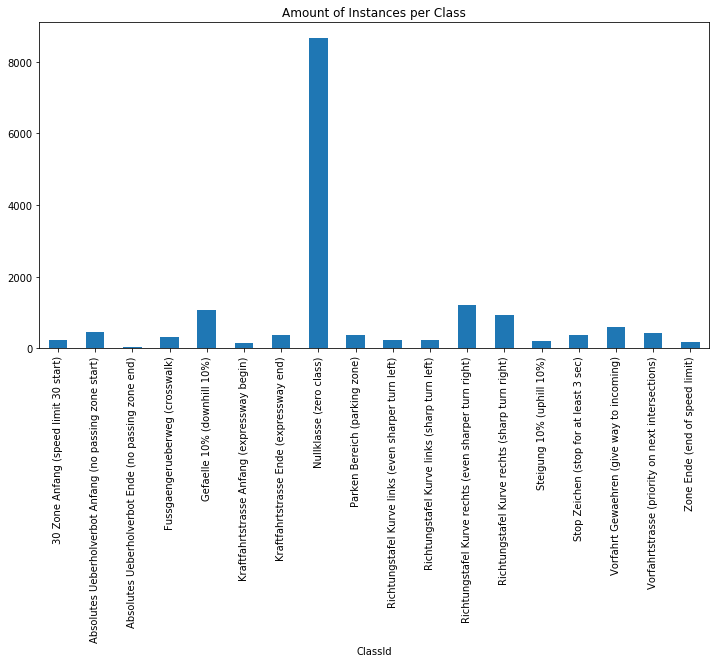

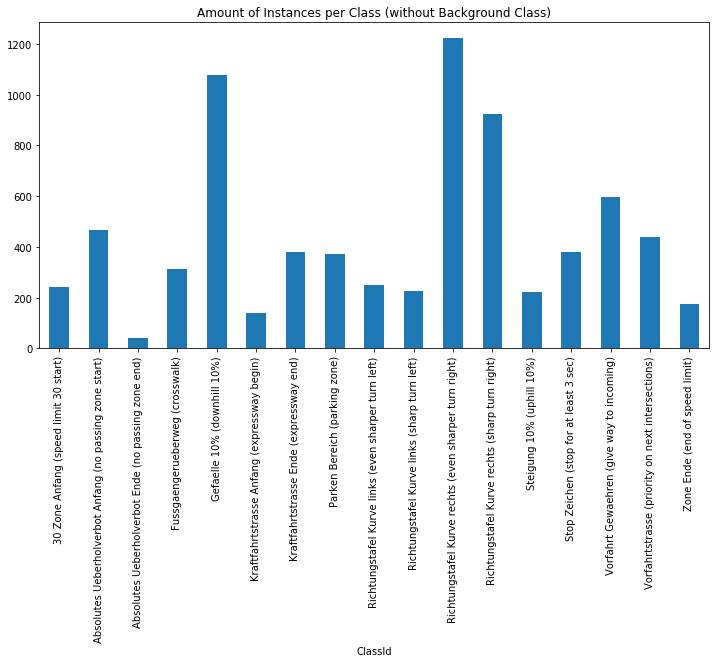

  Total Amount: 16134
Minimum Amount: 41
Maximum Amount: 8669
 Without empty: 7465

                                              ClassId  Amount
0               30 Zone Anfang (speed limit 30 start)     242
1   Absolutes Ueberholverbot Anfang (no passing zo...     466
2   Absolutes Ueberholverbot Ende (no passing zone...      41
3                     Fussgaengerueberweg (crosswalk)     311
4                         Gefaelle 10% (downhill 10%)    1077
5         Kraftfahrtstrasse Anfang (expressway begin)     141
6             Kraftfahrtstrasse Ende (expressway end)     378
7                             Nullklasse (zero class)    8669
8                       Parken Bereich (parking zone)     372
9   Richtungstafel Kurve links (even sharper turn ...     248
10       Richtungstafel Kurve links (sharp turn left)     228
11  Richtungstafel Kurve rechts (even sharper turn...    1224
12     Richtungstafel Kurve rechts (sharp turn right)     924
13                          Steigung 10% (uphill

In [25]:
# 1) Plot the distribution (with background class).
grouped_classes = df.groupby('ClassId').count()['Width']  # Group the dataframe by classes.
grouped_classes.plot(kind='bar', figsize=(12,6),  title='Amount of Instances per Class', legend=False)
plt.show()

# 2) Plot without background class.
df_without_background = df.drop(df[df['ClassId'] == sign_names[43]].index)
df_without_background_grouped = df_without_background.groupby('ClassId').count()['Width']
df_without_background_grouped.plot(kind='bar', figsize=(12,6),  title='Amount of Instances per Class (without Background Class)', legend=False)
plt.show()
df_without_background_grouped = df_without_background_grouped.reset_index()
df_without_background_grouped.columns = ['ClassId', 'Amount']

# 3) Print statistics.
grouped_classes = grouped_classes.reset_index()  # Makes the index go from 0-17.
grouped_classes.columns = ['ClassId', 'Amount']  # Column renaming
print("  Total Amount: {}".format(grouped_classes['Amount'].sum()))
print("Minimum Amount: {}".format(grouped_classes['Amount'].min()))
print("Maximum Amount: {}".format(grouped_classes['Amount'].max()))
print(" Without empty: {}\n".format(grouped_classes['Amount'].sum() - grouped_classes['Amount'].max()))
print(grouped_classes)

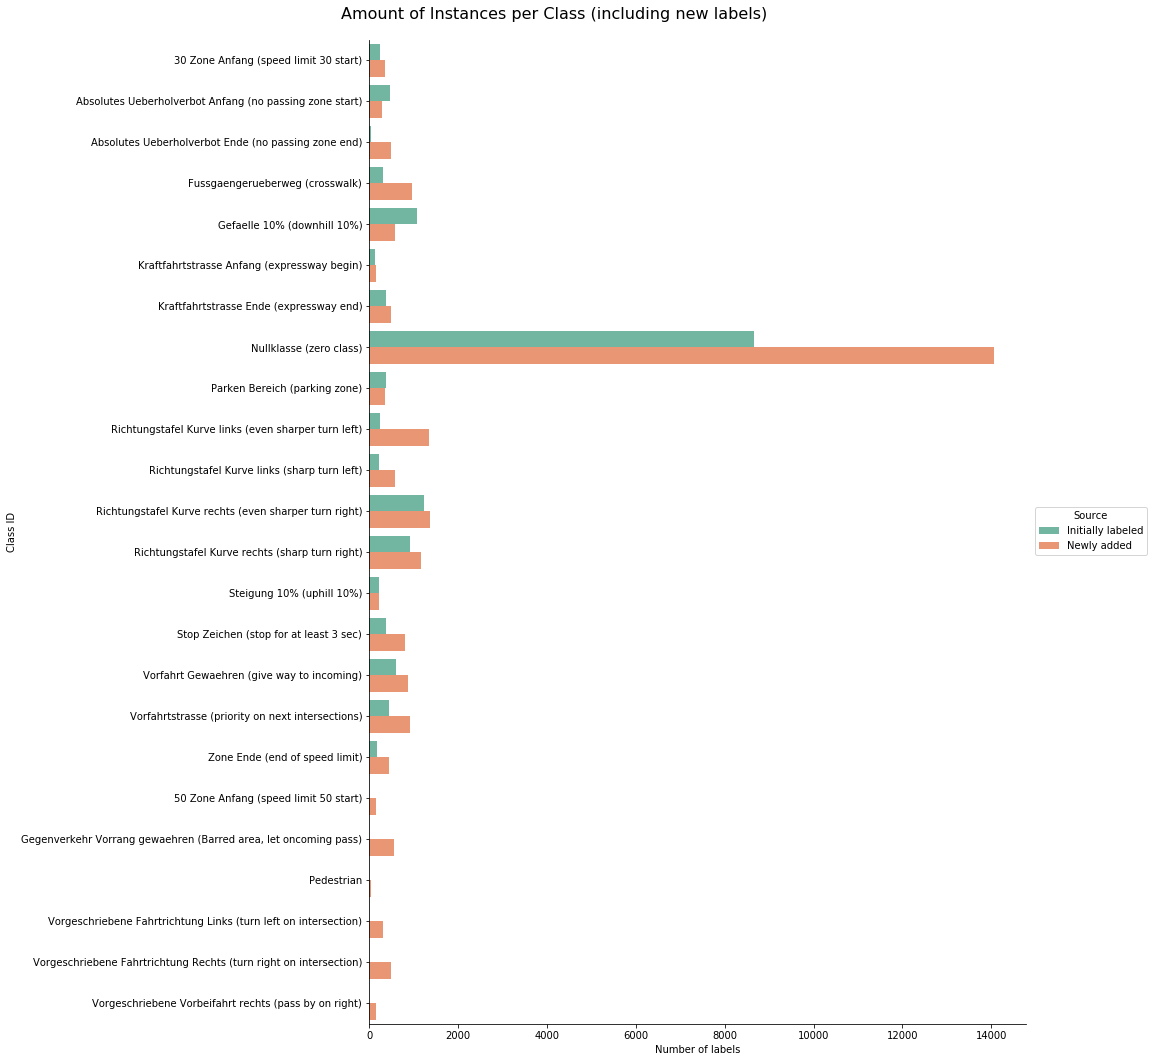

In [41]:
# 4) Plot the distribution with the newly added data
grouped_original = df.groupby(['ClassId']).count()
grouped_new = df_added_april.groupby(['ClassId']).count()
df_comparison = pd.concat([grouped_original, grouped_new], axis=0, ignore_index=False)
df_comparison['Source'] = (len(grouped_original)*('Initially labeled',) + len(grouped_new)*('Newly added',))
df_comparison.reset_index(level=0, inplace=True)
df_comparison.rename(columns={'ClassId': 'Class ID'}, inplace=True)
df_comparison['Number of labels'] = df_comparison['Filename']
df_comparison_wstop = df_comparison.copy()
df_comparison_wstop['Class ID'].replace(sign_names, inplace=True)
all_classes_plot = sns.factorplot(y='Class ID', x='Number of labels', hue='Source', kind='bar', 
                                  data=df_comparison_wstop, size=15, palette="Set2", orient='h')
all_classes_plot.fig.subplots_adjust(top=0.95)
all_classes_plot.fig.suptitle('Amount of Instances per Class (including new labels)', fontsize=16)
plt.show()

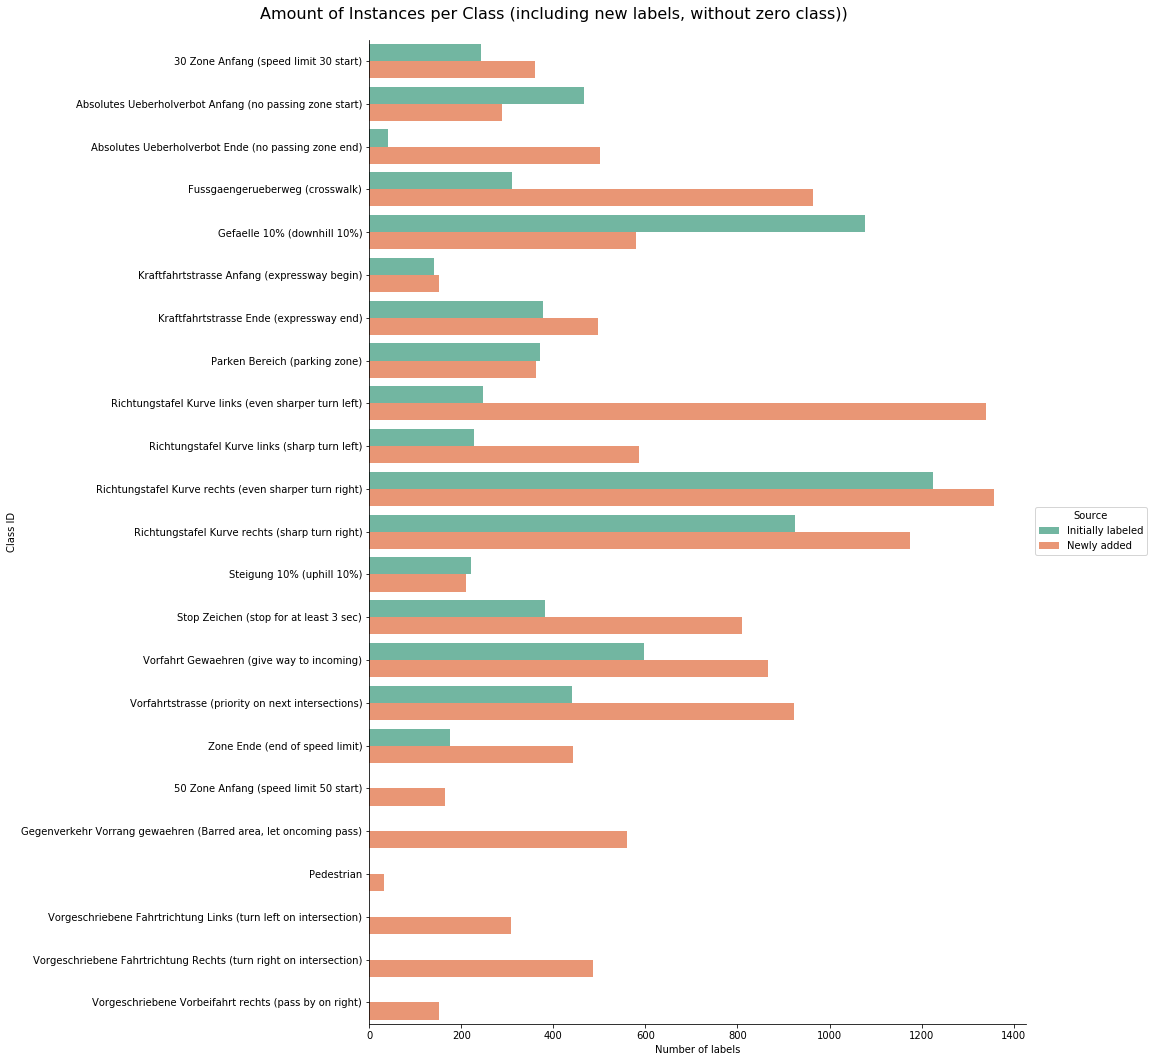

In [19]:
# 5) Plot the distribution with the newly added data, but without the zero class
df_comparison.drop(df_comparison[df_comparison['Class ID'] == sign_names[43]].index, inplace=True)
df_comparison['Class ID'].replace(sign_names, inplace=True)
all_classes_plot = sns.factorplot(y='Class ID', x='Number of labels', hue='Source', kind='bar', 
                                  data=df_comparison, size=15, palette="Set2", orient='h')
all_classes_plot.fig.subplots_adjust(top=0.95)
all_classes_plot.fig.suptitle('Amount of Instances per Class (including new labels, without zero class))', fontsize=16)
plt.show()